In [281]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [283]:
import sys
sys.path.append('..')

from util.participant_stream import ParticipantStream

In [284]:
# restrict rng for reproducibility
rng = np.random.default_rng(3098)

# Theoretical KDE
Consider the problem of uniformly sampling all possible age pairs:  
- assume that a pair is of the form (younger_age, older_age)
- range of possible ages are 19 - 80

In [285]:
def continuous_uniform_range_pair(lower_bound, upper_bound, num_samples):
    samples = rng.uniform(lower_bound, upper_bound, (2, num_samples))
    for i in range(num_samples):
        while samples[0,i] == samples[1,i]:
            samples[0,i] = rng.uniform(lower_bound, upper_bound)
            samples[1,i] = rng.uniform(lower_bound, upper_bound)
        if samples[0,i] > samples[1, i]:
            samples[0,i], samples[1,i] = samples[1,i], samples[0,i]
    return samples

In [286]:
theory_num_samples = 50000
theory_samples = continuous_uniform_range_pair(19, 80, theory_num_samples)

In [287]:
# visualize distribution of theoretical surface
bins = 60
t_hist, t_younger_edges, t_older_edges = np.histogram2d(theory_samples[0], theory_samples[1], bins=bins, range=[[19,80],[19,80]], density=True)

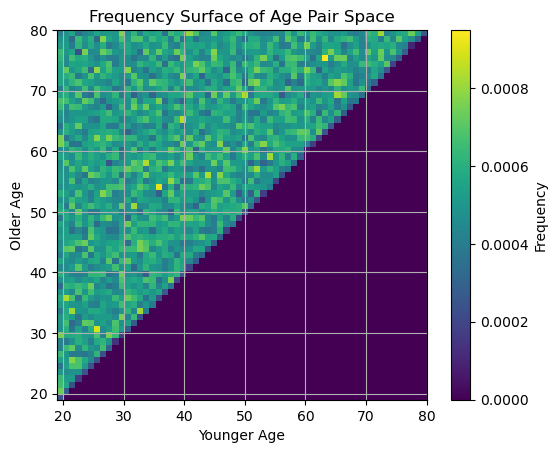

In [288]:
plt.imshow(t_hist.T, origin='lower', extent=[19, 80, 19, 80])
plt.colorbar(label='Frequency')
plt.title('Frequency Surface of Age Pair Space')
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

In [289]:
np.average(t_hist[t_hist != 0])

0.0005286786118661914

In [290]:
# define function for sampling from theoretical pdf
def generate_hist2d_pdf(hist, x_edges, y_edges):
    def sample_pdf(x, y):
        x_bin = np.argmax(np.where((np.expand_dims(x_edges, axis=1) < x).transpose(), x_edges, 0), axis=1)
        y_bin = np.argmax(np.where((np.expand_dims(y_edges, axis=1) < y).transpose(), y_edges, 0), axis=1)
        return hist[x_bin, y_bin]
    return sample_pdf
age_pdf = generate_hist2d_pdf(t_hist, t_younger_edges, t_older_edges)

# Algo 1: Greedy by All Pairs
1. Construct KDE over space of all possible pairs
2. Evaluate KDE on all possible pairs
3. Greedily select in order of lowest probability sample

## Simulation Setup

In [291]:
stream = ParticipantStream(rng=rng)

In [292]:
def generate_batch(n):
    return stream.generate_participants_normalized(n)

In [293]:
# list of datapoints across all batches
datapoints = None
# data_kde = GridSearchCV(KernelDensity(), {"bandwidth": np.logspace(-1, 1, 30)})
data_kde = KernelDensity(bandwidth=7.625, kernel='gaussian')
batches = 0
scores = {"linear": [], "squared": []}

In [294]:
def add_batch(samples: np.ndarray):
    # assuming samples come in the form of [[p1, p2], [p1, p2], ...]
    global datapoints, data_kde, batches
    if datapoints is not None:
        datapoints = np.vstack([datapoints, samples])
    else:
        datapoints = np.copy(samples)
    data_kde.fit(datapoints)
    batches += 1

In [295]:
def global_pdf(samples: np.ndarray):
    global datapoints, data_kde
    if datapoints is not None:
        return np.exp(data_kde.score_samples(samples))
    return np.zeros(samples.shape[0])

## Batch 1 Process

In [296]:
pool = generate_batch(100)

In [297]:
# extract age feature from participant metadata
ages = np.fromiter((p['age'] for p in pool), dtype=int)
ages_normalized = np.fromiter((p['n_age'] for p in pool), dtype=int)

In [298]:
# sample possible pairs to build kde
sampled_pairs = rng.choice(ages, (2, 10000)).transpose()
sampled_pairs_normalized = (sampled_pairs - 19) / (80 - 19)
# sample_pdf = GridSearchCV(KernelDensity(), {"bandwidth": np.logspace(-1, 1, 30)}).fit(sampled_pairs).best_estimator_
sample_pdf = KernelDensity(bandwidth=7.625, kernel='gaussian').fit(sampled_pairs)
sampled_pairs

array([[45, 28],
       [53, 56],
       [50, 50],
       ...,
       [39, 52],
       [53, 23],
       [65, 21]])

In [299]:
sample_pdf.bandwidth_

7.625

In [300]:
# get all possible pairings given pool
all_pairs = combinations(ages, 2)
all_pairs = np.array(list(all_pairs))
all_pairs

array([[31, 40],
       [31, 41],
       [31, 40],
       ...,
       [37, 75],
       [37, 53],
       [75, 53]])

In [301]:
all_pairs_normalized = (all_pairs - 19) / (80 - 19)
all_pairs_normalized

array([[0.19672131, 0.3442623 ],
       [0.19672131, 0.36065574],
       [0.19672131, 0.3442623 ],
       ...,
       [0.29508197, 0.91803279],
       [0.29508197, 0.55737705],
       [0.91803279, 0.55737705]])

In [302]:
# compute probability of the pairings occuring, adjusted by what's already in batch
all_pairs_prob = np.exp(sample_pdf.score_samples(all_pairs)) + global_pdf(all_pairs) # all_pairs_normalized
all_pairs_prob

array([0.00038964, 0.00039338, 0.00038964, ..., 0.00010802, 0.00041896,
       0.00012006])

In [303]:
# sort all pairs from lowest probability to highest probability
best_pairs = np.take(all_pairs, np.argsort(all_pairs_prob), axis=0)
best_pairs

array([[73, 75],
       [73, 75],
       [71, 75],
       ...,
       [46, 45],
       [46, 45],
       [46, 46]])

In [304]:
# Greedily pick pairs to sample
age_map = {}
for p in pool:
    if p['age'] not in age_map:
        age_map[p['age']] = [p]
    else:
        age_map[p['age']].append(p)
grouping = []
age_grouping = []
for pair in best_pairs:
    p1 = int(pair[0])
    p2 = int(pair[1])
    if p1 > p2:
        p1, p2 = p2, p1
    if p1 not in age_map or p2 not in age_map:
        continue
    if p1 == p2 and len(age_map[p1]) < 2:
        continue
    participant1 = age_map[p1].pop()
    participant2 = age_map[p2].pop()
    grouping.append((participant1, participant2))
    age_grouping.append([participant1['age'], participant2['age']])
    if len(age_map[p1]) == 0:
        del age_map[p1]
    if p2 != p1 and len(age_map[p2]) == 0:
        del age_map[p2]
    if not age_map:
        break
grouping

[({'party': 'Independent',
   'age': 73,
   'gender': 'M',
   'arrival_time': 11,
   'departure_time': 17,
   'n_party': 0,
   'n_age': 0.8852459016393442,
   'n_gender': 0},
  {'party': 'Democrat',
   'age': 75,
   'gender': 'M',
   'arrival_time': 231,
   'departure_time': 243,
   'n_party': 1,
   'n_age': 0.9180327868852459,
   'n_gender': 0}),
 ({'party': 'Democrat',
   'age': 71,
   'gender': 'M',
   'arrival_time': 43,
   'departure_time': 99,
   'n_party': 1,
   'n_age': 0.8524590163934426,
   'n_gender': 0},
  {'party': 'Republican',
   'age': 73,
   'gender': 'M',
   'arrival_time': 7,
   'departure_time': 29,
   'n_party': 0,
   'n_age': 0.8852459016393442,
   'n_gender': 0}),
 ({'party': 'Democrat',
   'age': 70,
   'gender': 'F',
   'arrival_time': 99,
   'departure_time': 175,
   'n_party': 1,
   'n_age': 0.8360655737704918,
   'n_gender': 1},
  {'party': 'Republican',
   'age': 70,
   'gender': 'M',
   'arrival_time': 20,
   'departure_time': 34,
   'n_party': 0,
   'n_ag

In [305]:
len(grouping)

50

In [306]:
age_grouping[:5]

[[73, 75], [71, 73], [70, 70], [68, 70], [66, 67]]

In [307]:
# update sampled dataset
add_batch(np.array(age_grouping))

In [308]:
datapoints.shape

(50, 2)

## Evaluate Batch 1

In [309]:
data_kde.bandwidth_

7.625

In [310]:
# sample every bin of kde
grid_x, grid_y = np.arange(19, 81), np.arange(19, 81)
x_coords, y_coords = np.meshgrid(grid_x, grid_y)
pos = np.vstack([x_coords.ravel(), y_coords.ravel()]).T
normalized_pos = (pos - 19) / (80 - 19)
z = np.reshape(global_pdf(pos), x_coords.shape) # normalized_pos

In [363]:
pos

array([[19, 19],
       [20, 19],
       [21, 19],
       ...,
       [78, 80],
       [79, 80],
       [80, 80]])

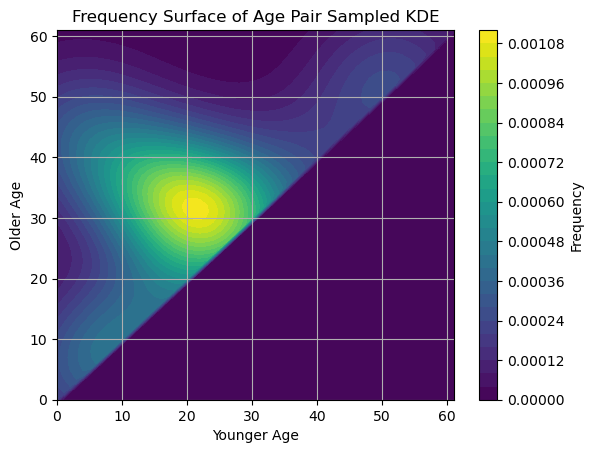

In [364]:
# plot kde
plt.contourf(np.tril(z), levels=30, cmap='viridis')
plt.colorbar(label='Frequency')
plt.title('Frequency Surface of Age Pair Sampled KDE')
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

In [312]:
# compute difference between theoretical and dataset at every bin
dif = np.reshape((age_pdf(pos.T[0], pos.T[1]) - global_pdf(pos)), x_coords.shape)

In [313]:
np.sum(age_pdf(pos.T[0], pos.T[1]))

1.0323611932276267

In [314]:
np.sum(global_pdf(pos))

0.894044310470621

In [315]:
dif

array([[ 5.38041407e-05,  3.57380043e-05, -2.31952697e-04, ...,
        -7.58251117e-11, -4.49087849e-11, -2.63661300e-11],
       [ 3.52563900e-05,  1.50218507e-05, -2.54755863e-04, ...,
        -1.25498960e-10, -7.49029185e-11, -4.43117111e-11],
       [ 5.02248854e-04,  4.79908305e-04, -4.78167442e-06, ...,
        -2.05724647e-10, -1.23715235e-10, -7.37379976e-11],
       ...,
       [ 4.44347190e-04,  4.42177746e-04,  4.59925712e-04, ...,
         1.83117147e-04, -9.41302941e-05, -8.13997223e-05],
       [ 3.75866527e-04,  3.74225164e-04,  4.50428708e-04, ...,
         4.44997325e-04,  1.66376452e-04,  1.77794649e-04],
       [ 3.83143111e-04,  3.81919261e-04,  4.58438543e-04, ...,
         4.55676629e-04,  1.75670288e-04,  1.85755919e-04]])

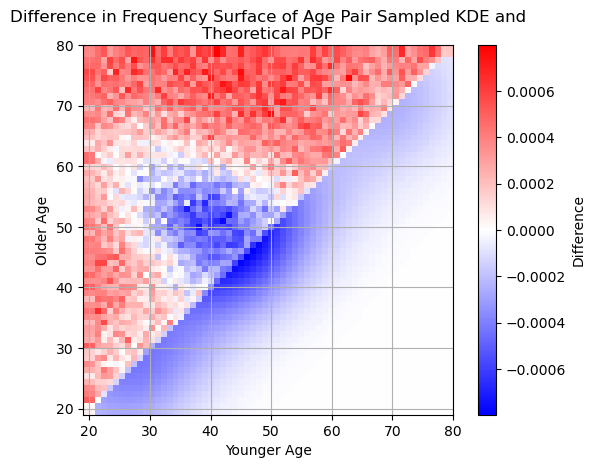

In [316]:
# plot difference
cmap_max = np.max(np.abs(dif))
plt.imshow(dif, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
plt.colorbar(label='Difference')
plt.title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

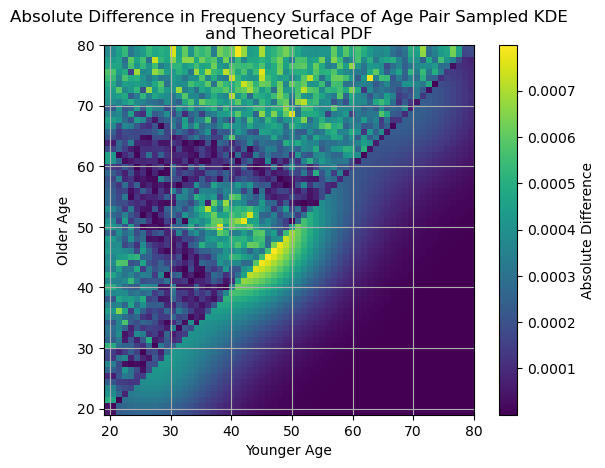

In [317]:
# plot abs difference
plt.imshow(np.abs(dif), origin='lower', extent=[19, 80, 19, 80])
plt.colorbar(label='Absolute Difference')
plt.title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF' , wrap=True)
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

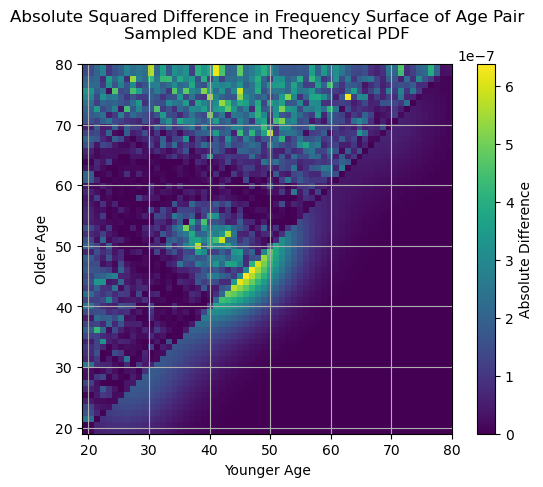

In [318]:
# plot squared difference
plt.imshow(np.abs(dif ** 2), origin='lower', extent=[19, 80, 19, 80])
plt.colorbar(label='Absolute Difference')
plt.title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
plt.xlabel('Younger Age')
plt.ylabel('Older Age')
plt.grid(True)
plt.show()

In [319]:
# linear score
np.sum(np.tril(np.abs(dif)))

0.6086895927017479

In [320]:
# square score
np.sum(np.tril(np.abs(dif ** 2)))

0.00024930547695643297

# Batch 2 - N

In [321]:
def run_batch():
    pool = generate_batch(100)
    # extract age feature from participant metadata
    ages = np.fromiter((p['age'] for p in pool), dtype=int)
    # sample possible pairs to build kde
    sampled_pairs = rng.choice(ages, (10000, 2))
    sample_pdf = KernelDensity(bandwidth=7.625, kernel='gaussian').fit(sampled_pairs)
    # get all possible pairings given pool
    all_pairs = np.array(list(combinations(ages, 2)))
    # compute probability of the pairings occuring, adjusted by what's already in batch
    all_pairs_prob = np.exp(sample_pdf.score_samples(all_pairs)) + global_pdf(all_pairs) 
    # sort all pairs from lowest probability to highest probability
    best_pairs = np.take(all_pairs, np.argsort(all_pairs_prob), axis=0)
    # Greedily pick pairs to sample
    age_map = {}
    for p in pool:
        if p['age'] not in age_map:
            age_map[p['age']] = [p]
        else:
            age_map[p['age']].append(p)
    grouping = []
    age_grouping = []
    for pair in best_pairs:
        p1 = int(pair[0])
        p2 = int(pair[1])
        if p1 > p2:
            p1, p2 = p2, p1
        if p1 not in age_map or p2 not in age_map:
            continue
        if p1 == p2 and len(age_map[p1]) < 2:
            continue
        grouping.append((age_map[p1].pop(), age_map[p2].pop()))
        age_grouping.append([p1, p2])
        if len(age_map[p1]) == 0:
            del age_map[p1]
        if p2 != p1 and len(age_map[p2]) == 0:
            del age_map[p2]
        if not age_map:
            break
    # update sampled dataset
    add_batch(np.array(age_grouping))

In [322]:
def evaluate_dataset(plot=False):
    grid_x, grid_y = np.arange(19, 81), np.arange(19, 81)
    x_coords, y_coords = np.meshgrid(grid_x, grid_y)
    pos = np.vstack([x_coords.ravel(), y_coords.ravel()]).T
    
    z = np.tril(np.reshape(global_pdf(pos), x_coords.shape))
    dif = np.reshape((age_pdf(pos.T[0], pos.T[1]) - global_pdf(pos)), x_coords.shape)
    
    if plot:
        fig, axes = plt.subplots(4, 1, figsize=(6, 20))

        a0 = axes[0].contourf(x_coords, y_coords, z, levels=30, vmin=0, vmax=0.0015)
        fig.colorbar(a0, ax=axes[0], label='Frequency')
        axes[0].set_title('Frequency Surface of Age Pair Sampled KDE')
        axes[0].set_xlabel('Younger Age')
        axes[0].set_ylabel('Older Age')
        axes[0].grid(True)
        
        cmap_max = np.max(np.abs(dif))
        a1 = axes[1].imshow(dif, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
        fig.colorbar(a1, ax=axes[1], label='Difference')
        axes[1].set_title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[1].set_xlabel('Younger Age')
        axes[1].set_ylabel('Older Age')
        axes[1].grid(True)

        a2 = axes[2].imshow(np.abs(dif), origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a2, ax=axes[2], label='Absolute Difference')
        axes[2].set_title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[2].set_xlabel('Younger Age')
        axes[2].set_ylabel('Older Age')
        axes[2].grid(True)

        a3 = axes[3].imshow(np.abs(dif ** 2), origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a3, ax=axes[3], label='Absolute Squared Difference')
        axes[3].set_title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
        axes[3].set_xlabel('Younger Age')
        axes[3].set_ylabel('Older Age')
        axes[3].grid(True)   

        fig.tight_layout()

    return {"linear": np.sum(np.tril(np.abs(dif))), "squared": np.sum(np.tril(np.abs(dif ** 2)))}

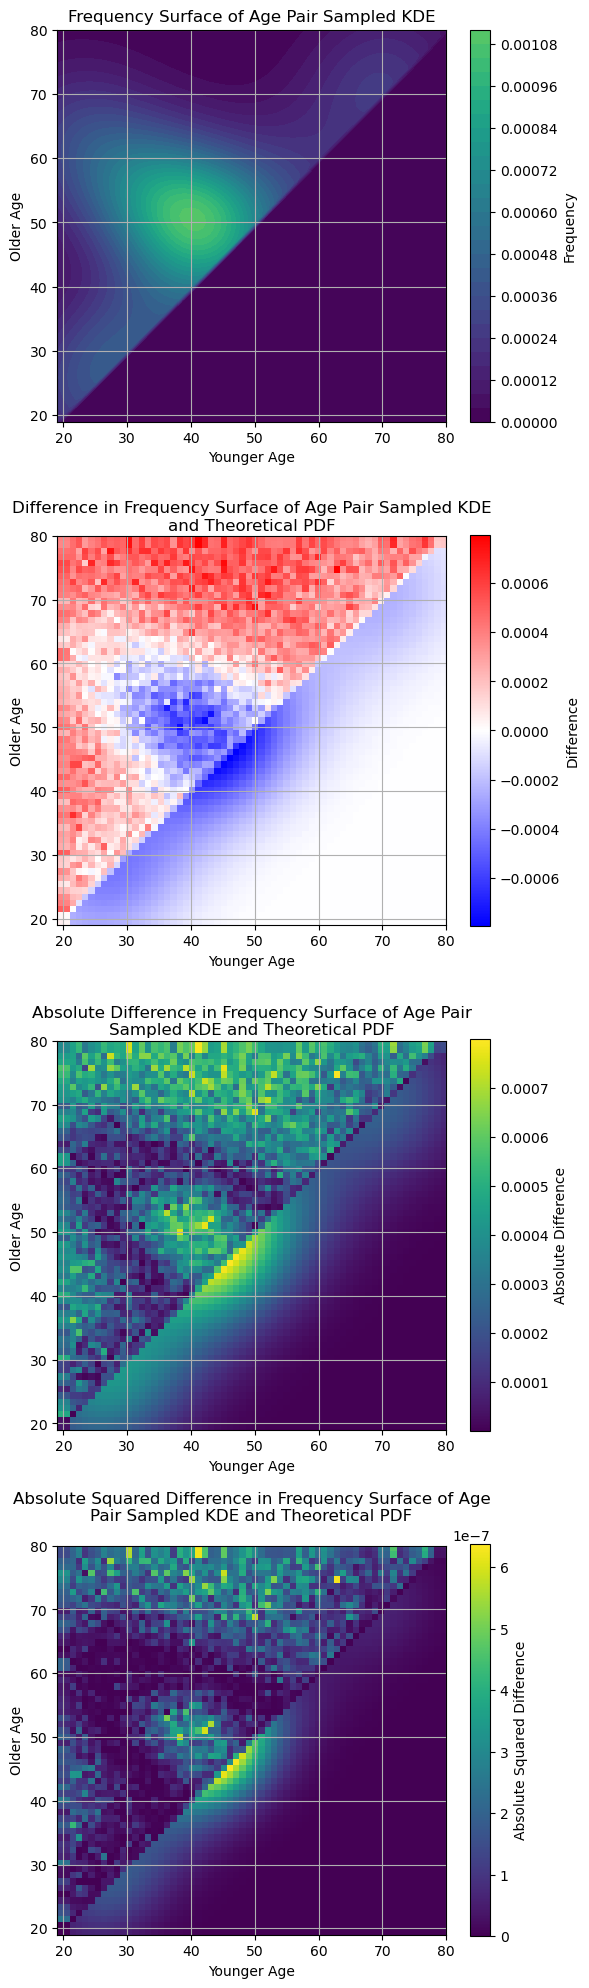

In [323]:
res = evaluate_dataset(plot=True)
scores["linear"].append(res['linear'])
scores["squared"].append(res['squared'])
# scores

{'linear': [0.6086895927017479, 0.6642466829006262],
 'squared': [0.00024930547695643297, 0.0002895626103082004]}

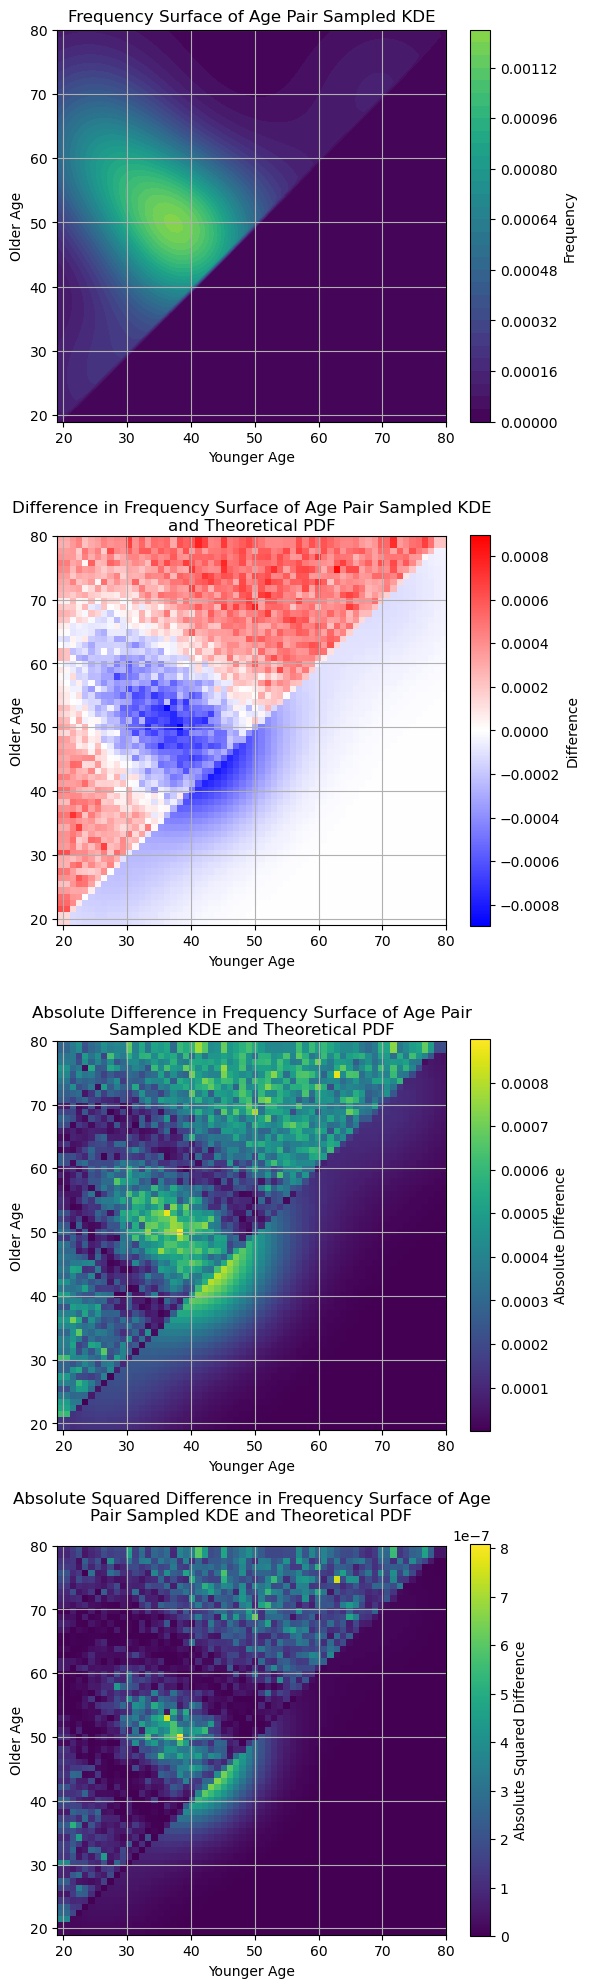

In [324]:
# BATCH 2
run_batch()
res = evaluate_dataset(plot=True)
scores["linear"].append(res['linear'])
scores["squared"].append(res['squared'])
scores

{'linear': [0.6086895927017479,
  0.6642466829006262,
  0.663302331548032,
  0.6657381157937661,
  0.6831607126483495,
  0.6962779651057192,
  0.7080597536274984,
  0.7069261727628651,
  0.7140349241876591,
  0.718149742297885],
 'squared': [0.00024930547695643297,
  0.0002895626103082004,
  0.0002893260260387766,
  0.0002941599184710958,
  0.00030939852619706054,
  0.00032219261953491573,
  0.00033258079528332115,
  0.00033192521684994897,
  0.00033921170985510337,
  0.00034388205098068153]}

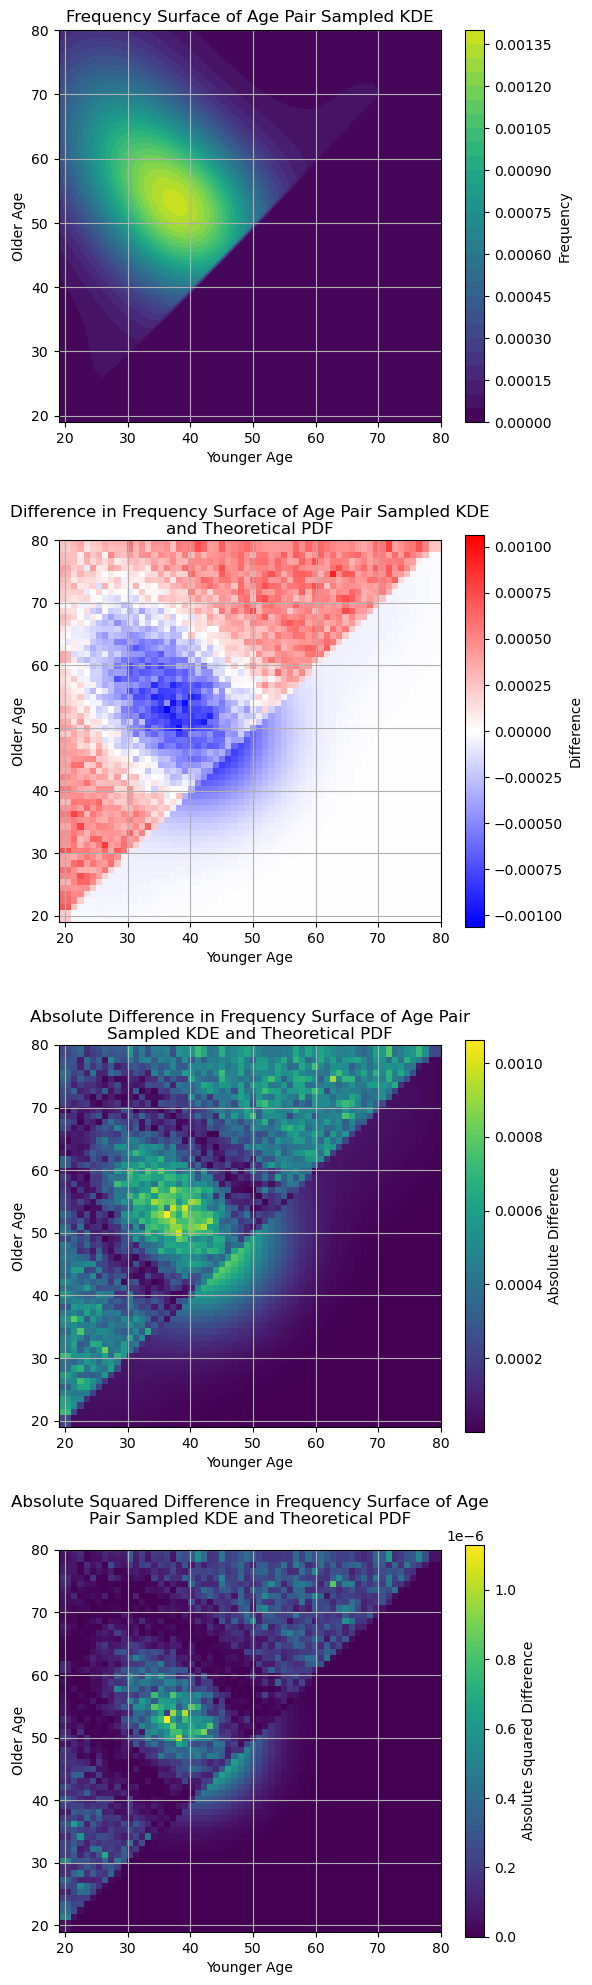

In [325]:
#10th batch
for i in range(8):
    run_batch()
    res = evaluate_dataset()
    scores["linear"].append(res['linear'])
    scores["squared"].append(res['squared'])
evaluate_dataset(plot=True)
scores

{'linear': 0.7500980353177229, 'squared': 0.00037600092614138394}

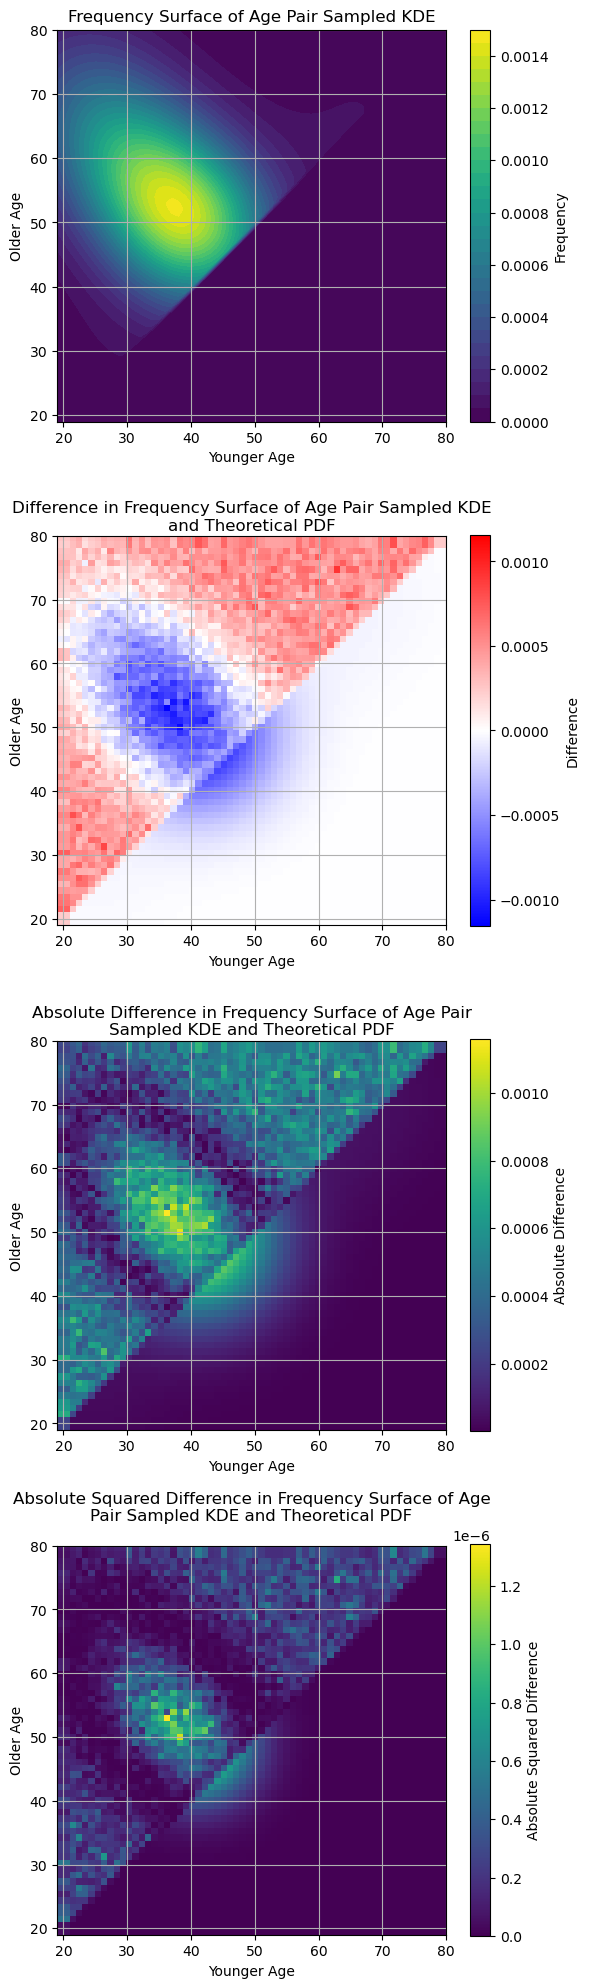

In [326]:
# 100th batches
for i in range(90):
    run_batch()
    res = evaluate_dataset()
    scores["linear"].append(res['linear'])
    scores["squared"].append(res['squared'])
evaluate_dataset(plot=True)

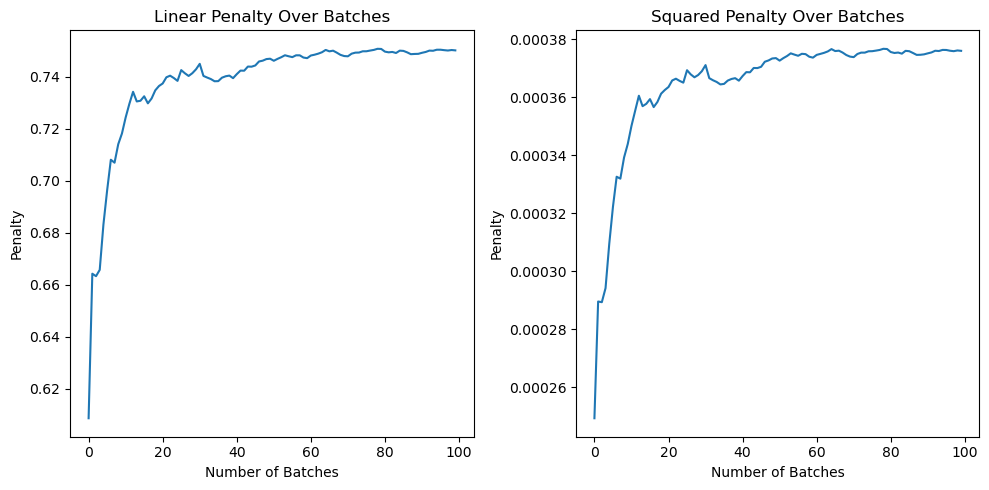

In [327]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(scores['linear'], label='linear')
ax[0].set_title("Linear Penalty Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Penalty')

ax[1].plot(scores['squared'], label='squared')
ax[1].set_title("Squared Penalty Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Penalty')
fig.tight_layout()

In [328]:
scores['linear'][-1]

0.7500980353177229

In [329]:
scores['squared'][-1]

0.00037600092614138394

Run 100 batches 100 times to get a smooth penalty curve
Then plot this against baseline to see how fast it converges

 # Baseline Check

In [330]:
b_stream = ParticipantStream(seed=3098)
b_samples = None
b_kde = KernelDensity(bandwidth=7.625, kernel='gaussian')
b_scores = {'linear': [], 'squared': []}

In [331]:
def run_baseline_batch(size):
    global b_samples, b_kde
    size = size >> 1 << 1
    b_pool = b_stream.generate_participants(size)
    bs = np.zeros((size >> 1, 2))
    for i in range(0, len(b_pool), 2):
        if b_pool[i]['age'] < b_pool[i+1]['age']:
            bs[i//2, 0] = b_pool[i]['age']
            bs[i//2, 1] = b_pool[i+1]['age']
        else:
            bs[i//2, 0] = b_pool[i+1]['age']
            bs[i//2, 1] = b_pool[i]['age']
    if b_samples is not None:
        b_samples = np.vstack([b_samples, bs])
    else:
        b_samples = np.copy(bs)
    b_kde.fit(b_samples)

In [332]:
def evaluate_baseline_batch(plot = False):
    b_x_coords, b_y_coords = np.meshgrid(np.arange(19, 81), np.arange(19, 81))
    b_pos = np.vstack([b_x_coords.ravel(), b_y_coords.ravel()]).T
    b_z = np.tril(np.reshape(np.exp(b_kde.score_samples(b_pos)), b_x_coords.shape))
    b_dif = np.reshape((age_pdf(b_pos.T[0], b_pos.T[1]) - np.exp(b_kde.score_samples(b_pos))), b_x_coords.shape)

    if plot:
        fig, axes = plt.subplots(4, 1, figsize=(6, 20))

        a0 = axes[0].contourf(b_x_coords, b_y_coords, b_z, levels=30, vmin=0, vmax=0.0015)
        fig.colorbar(a0, ax=axes[0], label='Frequency')
        axes[0].set_title('Frequency Surface of Age Pair Sampled KDE')
        axes[0].set_xlabel('Younger Age')
        axes[0].set_ylabel('Older Age')
        axes[0].grid(True)

        cmap_max = np.max(np.abs(b_dif))
        a1 = axes[1].imshow(b_dif, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
        fig.colorbar(a1, ax=axes[1], label='Difference')
        axes[1].set_title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[1].set_xlabel('Younger Age')
        axes[1].set_ylabel('Older Age')
        axes[1].grid(True)

        a2 = axes[2].imshow(np.abs(b_dif), origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a2, ax=axes[2], label='Absolute Difference')
        axes[2].set_title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[2].set_xlabel('Younger Age')
        axes[2].set_ylabel('Older Age')
        axes[2].grid(True)

        a3 = axes[3].imshow(np.abs(b_dif ** 2), origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a3, ax=axes[3], label='Absolute Squared Difference')
        axes[3].set_title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
        axes[3].set_xlabel('Younger Age')
        axes[3].set_ylabel('Older Age')
        axes[3].grid(True)   

        fig.tight_layout()

    return {"linear": np.sum(np.tril(np.abs(b_dif))), "squared": np.sum(np.tril(np.abs(b_dif ** 2)))}

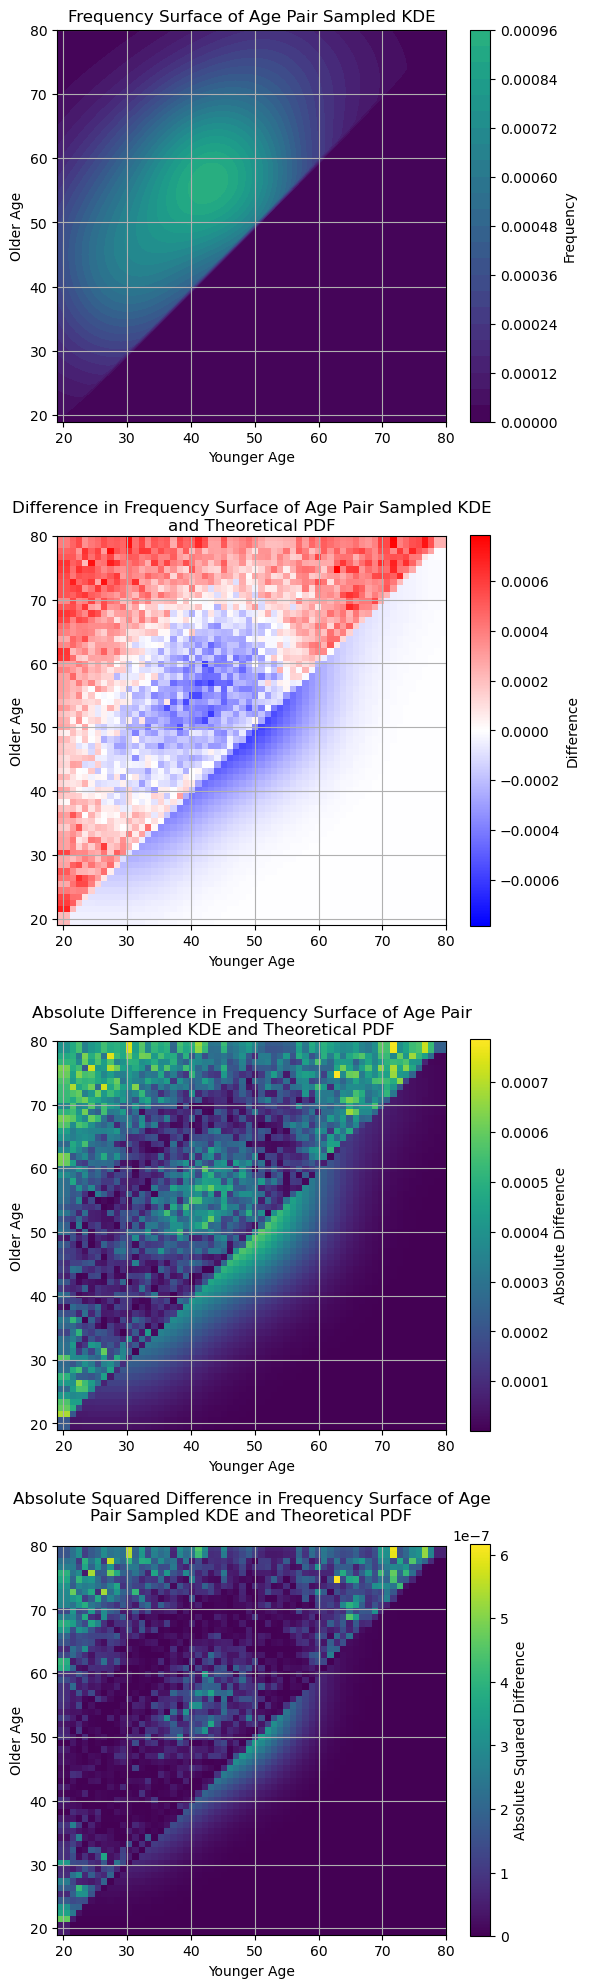

In [333]:
# batch 1
run_baseline_batch(100)
res = evaluate_baseline_batch(plot=True)
b_scores['linear'].append(res['linear'])
b_scores['squared'].append(res['squared'])

{'linear': 0.49316569627814977, 'squared': 0.0001746275292172018}

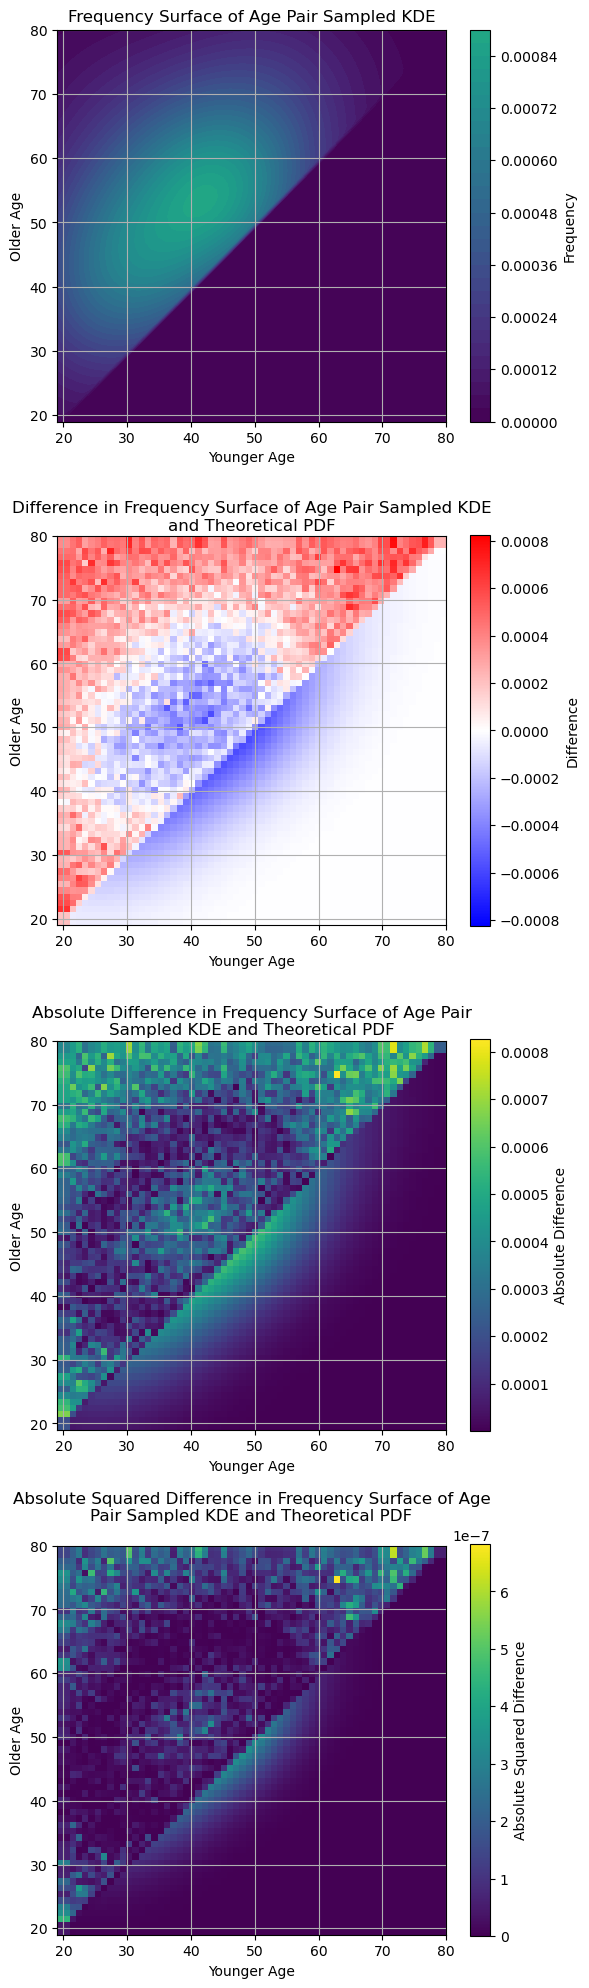

In [334]:
# batch 10
for i in range(9):
    run_baseline_batch(100)
    res = evaluate_baseline_batch()
    b_scores['linear'].append(res['linear'])
    b_scores['squared'].append(res['squared'])
evaluate_baseline_batch(plot=True)
    

{'linear': 0.4972228647861128, 'squared': 0.00017647095481909165}

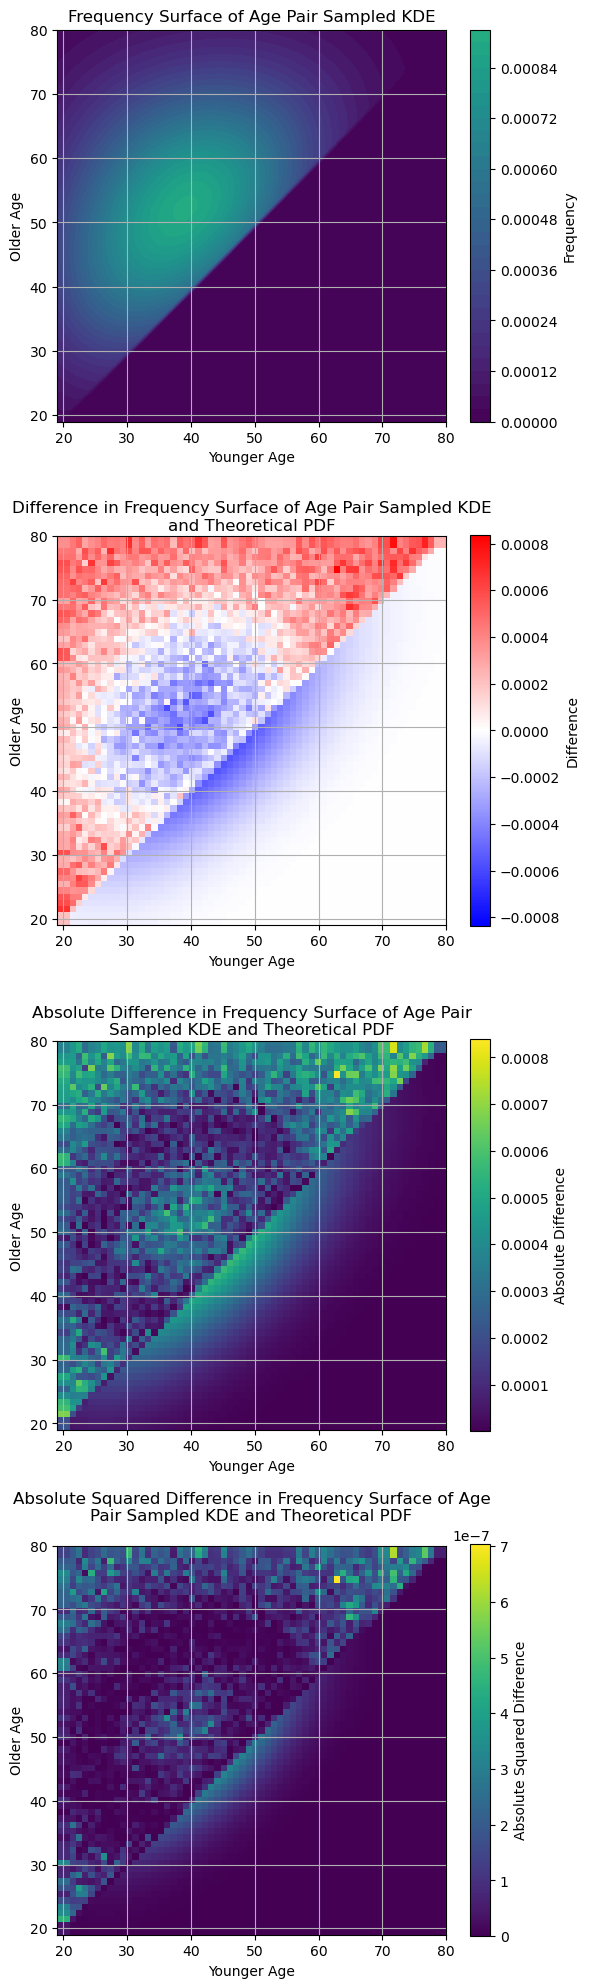

In [335]:
# batch 100
for i in range(90):
    run_baseline_batch(100)
    res = evaluate_baseline_batch()
    b_scores['linear'].append(res['linear'])
    b_scores['squared'].append(res['squared'])
evaluate_baseline_batch(plot=True)

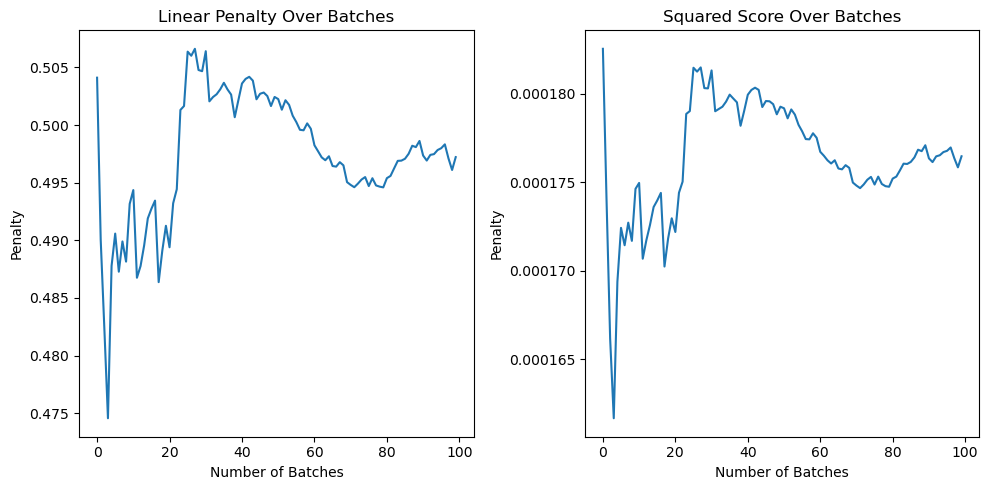

In [336]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(b_scores['linear'], label='linear')
ax[0].set_title("Linear Penalty Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Penalty')

ax[1].plot(b_scores['squared'], label='squared')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Penalty')
fig.tight_layout()

# Algo 2

In [348]:
a2_stream = ParticipantStream(seed=3098)
a2_datapoints = None
a2_kde = KernelDensity(bandwidth=7.625, kernel='gaussian')
a2_scores = {'linear': [], 'squared': []}
a2_batches = 0

In [349]:
def a2_generate_batch(n):
    return a2_stream.generate_participants_normalized(n)

In [350]:
def a2_add_batch(samples: np.ndarray):
    # assuming samples come in the form of [[p1, p2], [p1, p2], ...]
    global a2_datapoints, a2_kde, a2_batches
    if a2_datapoints is not None:
        a2_datapoints = np.vstack([a2_datapoints, samples])
    else:
        a2_datapoints = np.copy(samples)
    a2_kde.fit(a2_datapoints)
    # a2_batches += 1

In [351]:
def a2_pdf(samples: np.ndarray):
    global a2_datapoints, a2_kde
    if a2_datapoints is not None:
        return np.exp(a2_kde.score_samples(samples))
    return np.zeros(samples.shape[0])

In [352]:
def run_a2_batch():
    global a2_datapoints, a2_batches
    pool = a2_generate_batch(100)
    # extract age feature from participant metadata
    ages = np.fromiter((p['age'] for p in pool), dtype=int)
    # get map of unique ages to participants with age
    ptcp_cnt = {}
    for i, age in enumerate(ages):
        if age not in ptcp_cnt:
            ptcp_cnt[age] = [pool[i]]
        else:
            ptcp_cnt[age].append(pool[i])
    ptcp_unique = np.array(list(ptcp_cnt.keys()))
    # compute rarity of each person
    ptcp_pdf = KernelDensity(bandwidth=6.2, kernel='gaussian').fit(ages.reshape(-1, 1))
    
    groupings = []
    age_grouping = []
    # if no previous data, then group in order of rareness
    if True: # a2_datapoints is None:
        ptcp_rareness = np.exp(ptcp_pdf.score_samples(ages.reshape(-1,1)))
        ranked_idx = np.argsort(ptcp_rareness)
        for i in range(0, len(pool), 2):
            i1 = ranked_idx[i]
            i2 = ranked_idx[i+1]
            p1 = pool[i1]['age']
            p2 = pool[i2]['age']
            if p1 < p2:
                groupings.append((pool[i1], pool[i2]))
                age_grouping.append([p1, p2])
            else:
                groupings.append((pool[i2], pool[i1]))
                age_grouping.append([p2, p1])
        a2_add_batch(np.array(age_grouping))
    # otherwise, fix rarest person, then select most useful group with that person
    else:
        ptcp_rareness = np.exp(ptcp_pdf.score_samples(ptcp_unique.reshape(-1,1)))
        ptcp_unique = np.take(ptcp_unique, np.argsort(ptcp_rareness), axis=0)
        while ptcp_unique.shape[0] > 0:
            # select rarest feature set
            ptcp = ptcp_unique[0]
            # get all possible remaining pairs in order of least frequency in dataset (most undersampled)
            pairs = np.array([[ptcp, y] for y in ptcp_unique])
            pairs_prob = a2_pdf(pairs)
            best_pairs = np.take(pairs, np.argsort(pairs_prob), axis=0)
            # greedily pick pairs until ptcp with selected features are exhausted
            bp_idx = 0
            while ptcp_cnt[ptcp]:
                # pick first person
                p1 = ptcp_cnt[ptcp].pop()
                # try current most useful sample
                pair = best_pairs[bp_idx]
                # if sample is not available, remove from candidates
                if not ptcp_cnt[pair[1]]:
                    best_pairs = np.delete(best_pairs, bp_idx, axis=0)
                    if bp_idx >= best_pairs.shape[0]:
                        bp_idx = 0
                    continue
                # add group and set pointer to next most useful sample
                groupings.append((p1, ptcp_cnt[pair[1]].pop()))
                age_grouping.append(pair.tolist())
                bp_idx = bp_idx + 1 if bp_idx + 1 < best_pairs.shape[0] else 0
            if not ptcp_cnt[ptcp]:
                ptcp_unique = ptcp_unique[1:]
            if age_grouping:
                a2_add_batch(np.array(age_grouping))
                age_grouping = []
                groupings = []

    # update sampled dataset
    # a2_add_batch(np.array(age_grouping))
    a2_batches += 1

In [353]:
def evaluate_a2_dataset(plot=False):
    grid_x, grid_y = np.arange(19, 81), np.arange(19, 81)
    x_coords, y_coords = np.meshgrid(grid_x, grid_y)
    pos = np.vstack([x_coords.ravel(), y_coords.ravel()]).T
    
    z = np.tril(np.reshape(a2_pdf(pos), x_coords.shape))
    dif = np.reshape((age_pdf(pos.T[0], pos.T[1]) - a2_pdf(pos)), x_coords.shape)
    
    if plot:
        fig, axes = plt.subplots(4, 1, figsize=(6, 20))

        a0 = axes[0].contourf(x_coords, y_coords, z, levels=30, vmin=0, vmax=0.0015)
        fig.colorbar(a0, ax=axes[0], label='Frequency')
        axes[0].set_title('Frequency Surface of Age Pair Sampled KDE')
        axes[0].set_xlabel('Younger Age')
        axes[0].set_ylabel('Older Age')
        axes[0].grid(True)
        
        cmap_max = np.max(np.abs(dif))
        a1 = axes[1].imshow(dif, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
        fig.colorbar(a1, ax=axes[1], label='Difference')
        axes[1].set_title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[1].set_xlabel('Younger Age')
        axes[1].set_ylabel('Older Age')
        axes[1].grid(True)

        a2 = axes[2].imshow(np.abs(dif), origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a2, ax=axes[2], label='Absolute Difference')
        axes[2].set_title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
        axes[2].set_xlabel('Younger Age')
        axes[2].set_ylabel('Older Age')
        axes[2].grid(True)

        a3 = axes[3].imshow(np.abs(dif ** 2), origin='lower', extent=[19, 80, 19, 80])
        fig.colorbar(a3, ax=axes[3], label='Absolute Squared Difference')
        axes[3].set_title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
        axes[3].set_xlabel('Younger Age')
        axes[3].set_ylabel('Older Age')
        axes[3].grid(True)   

        fig.tight_layout()

    return {"linear": np.sum(np.tril(np.abs(dif))), "squared": np.sum(np.tril(np.abs(dif ** 2)))}

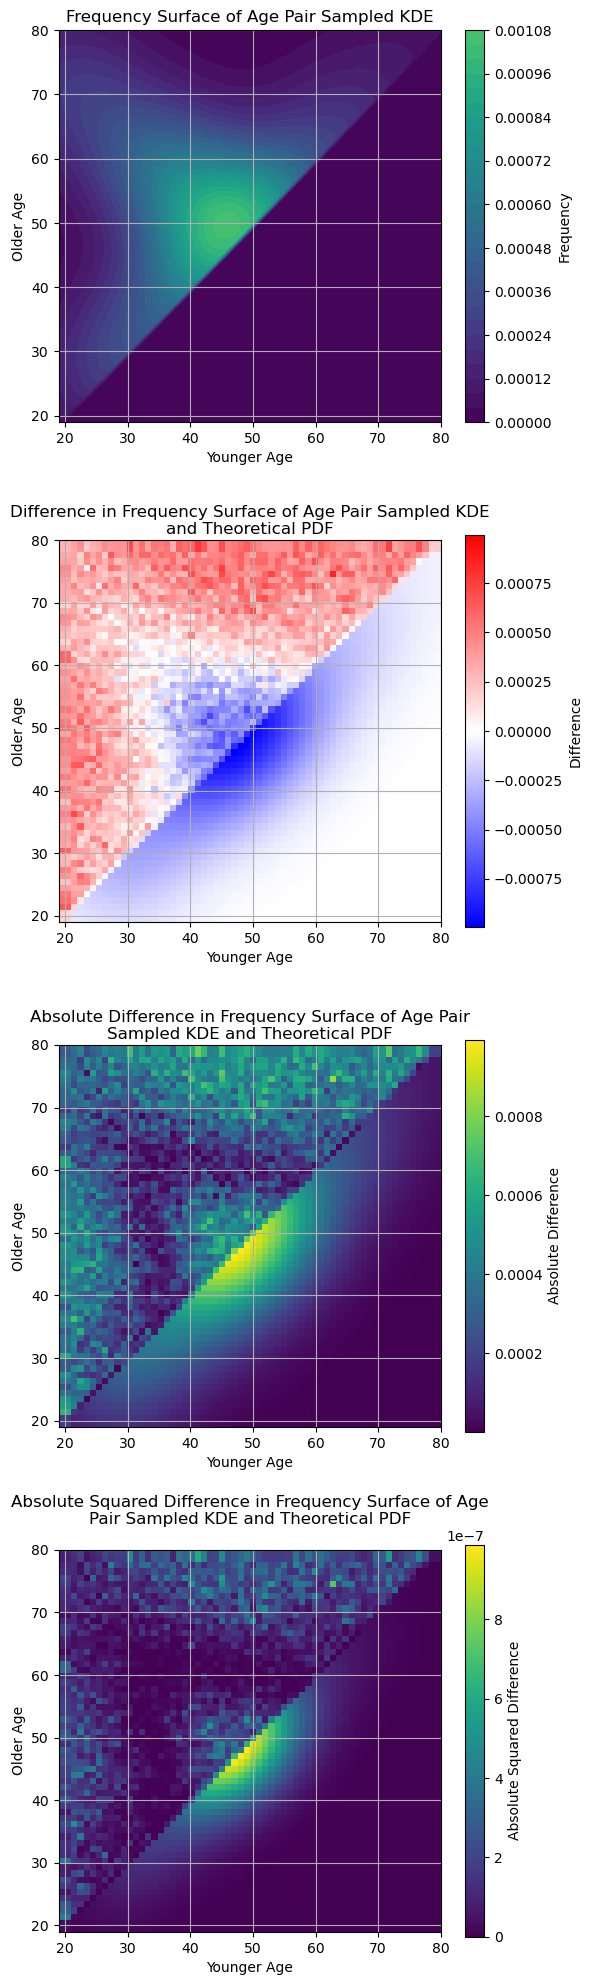

In [354]:
run_a2_batch()
res = evaluate_a2_dataset(plot=True)
a2_scores['linear'].append(res['linear'])
a2_scores['squared'].append(res['squared'])

{'linear': 0.6068928798625047, 'squared': 0.0002429571131626533}

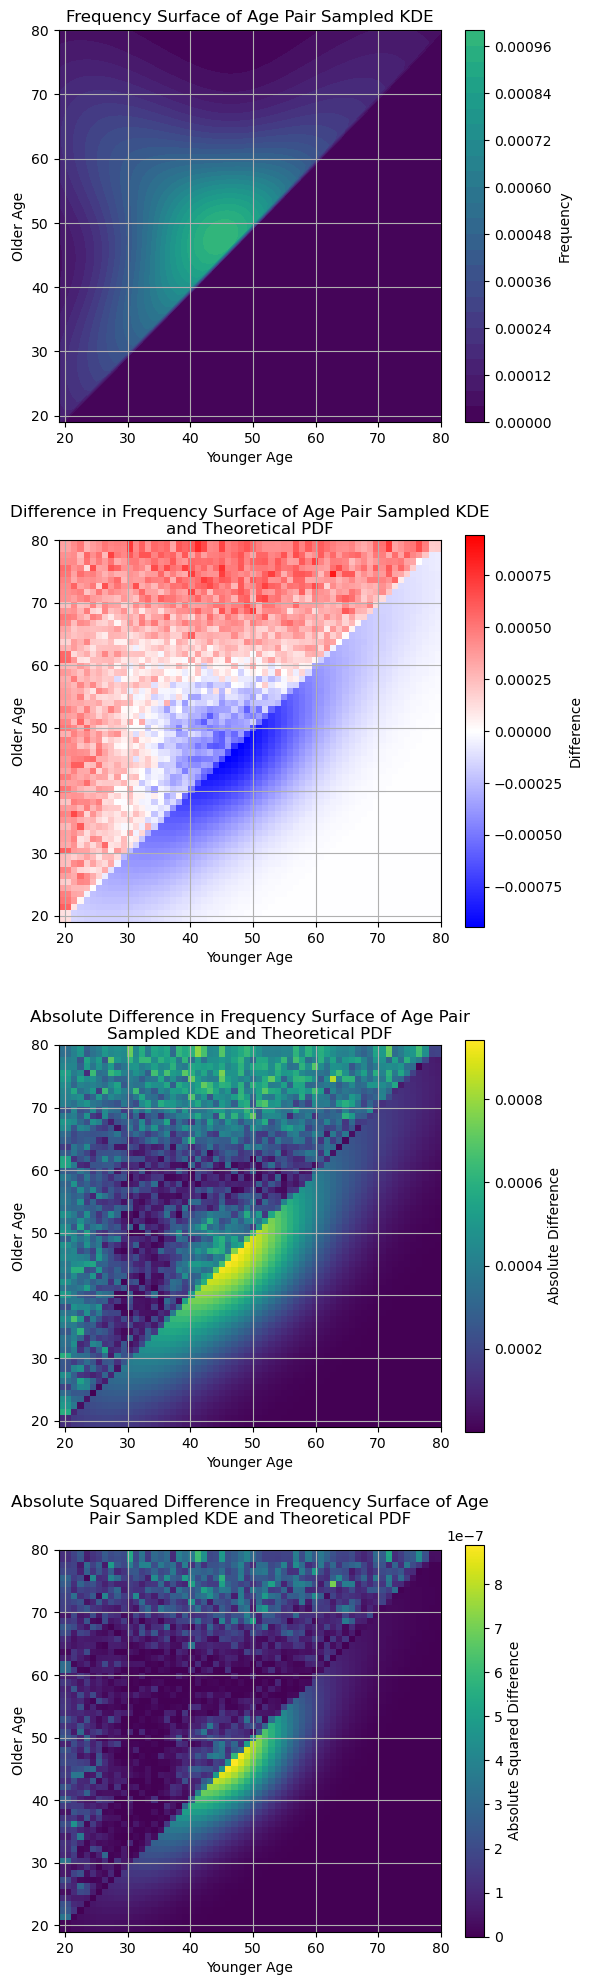

In [355]:
# batch 10
for i in range(9):
    run_a2_batch()
    res = evaluate_a2_dataset()
    a2_scores['linear'].append(res['linear'])
    a2_scores['squared'].append(res['squared'])
evaluate_a2_dataset(plot=True)
    

{'linear': 0.6042885144168235, 'squared': 0.00024067692246472713}

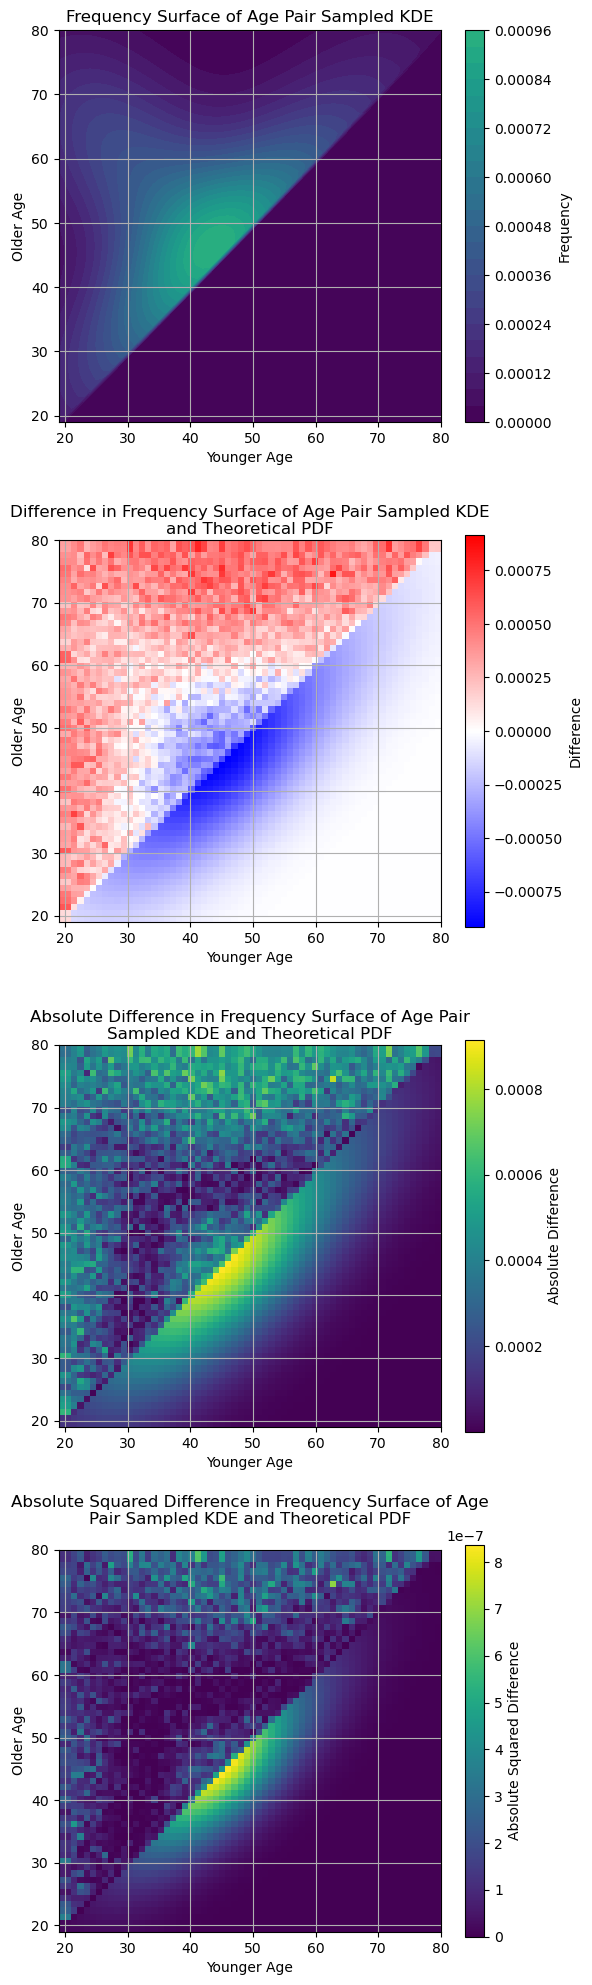

In [356]:
# batch 100
for i in range(90):
    run_a2_batch()
    res = evaluate_a2_dataset()
    a2_scores['linear'].append(res['linear'])
    a2_scores['squared'].append(res['squared'])
evaluate_a2_dataset(plot=True)

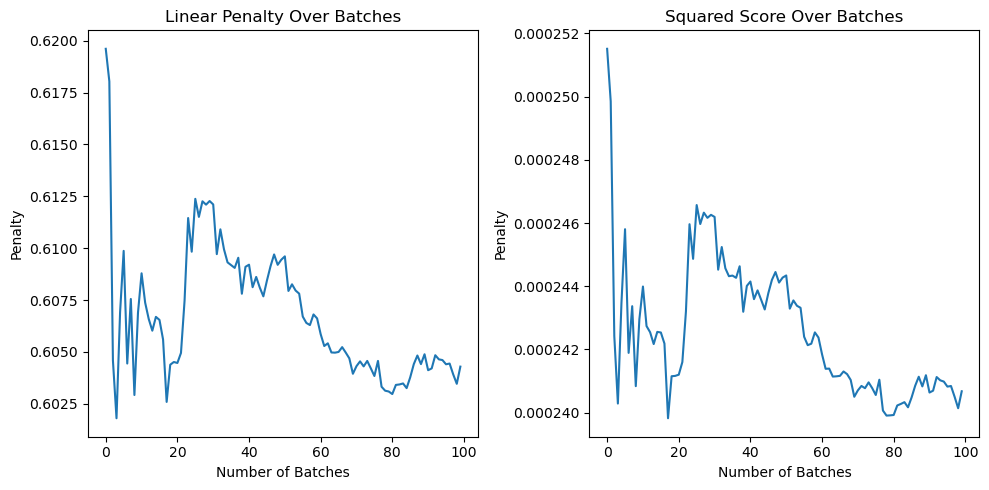

In [357]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(a2_scores['linear'], label='linear')
ax[0].set_title("Linear Penalty Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Penalty')

ax[1].plot(a2_scores['squared'], label='squared')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Penalty')
fig.tight_layout()

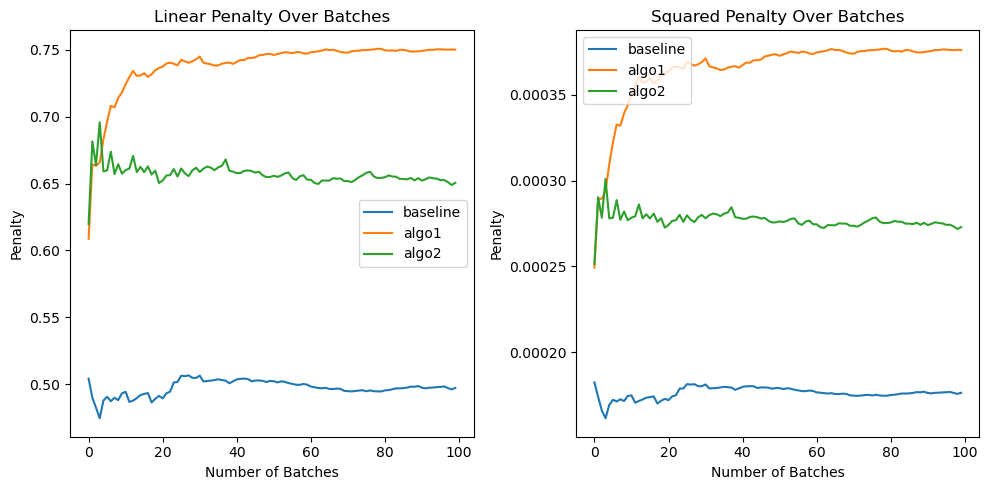

In [347]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(b_scores['linear'], label='baseline')
ax[0].plot(scores['linear'], label='algo1')
ax[0].plot(a2_scores['linear'], label='algo2')
ax[0].set_title("Linear Penalty Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Penalty')
ax[0].legend()

ax[1].plot(b_scores['squared'], label='baseline')
ax[1].plot(scores['squared'], label='algo1')
ax[1].plot(a2_scores['squared'], label='algo2')
ax[1].set_title("Squared Penalty Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Penalty')
ax[1].legend()
fig.tight_layout()
